# Ruble Volatility Project — Part 2: Exploratory Data Analysis

This notebook continues the Ruble Volatility Project by exploring trends and patterns in the cleaned dataset prepared in Part 1.

In this notebook (`02_Exploratory_Data_Analysis.ipynb`), I will:

1. Visualize historical trends in the ruble exchange rate (RUB/USD)
2. Compare RUB movements to key macroeconomic indicators (GDP, FDI, inflation, oil prices)
3. Analyze volatility across time, including crisis years
4. Explore structural breaks, rolling statistics, and correlations
5. Prepare data for forecasting and causal inference in future notebooks

**The main modeling and forecasting work will be carried out in the next notebooks, starting with** `03_Time_Series_Modeling.ipynb`.

In [ ]:
# Import the pandas_market_calendars module
# > Note: Some forecasting libraries are imported here in advance for use in Part 3 of the project.

%pip install pandas_market_calendars
import pandas_market_calendars as mcal
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


Note: you may need to restart the kernel to use updated packages.


### I. Loading data

Loading raw RUB exchange rate and macroeconomic data prepared in the previous notebook.

In [4]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Daily_Data2.csv", parse_dates=["date"])
data

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,125.2600,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,134.8000,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
2,130.5000,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
3,130.3000,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
4,130.2000,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7666,80.3466,2025-08-19,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7667,80.1045,2025-08-20,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7668,80.2548,2025-08-21,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000


### II. Descriptive Statistics


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   currency_rate   7670 non-null   float64       
 1   date            7670 non-null   datetime64[ns]
 2   year            7670 non-null   int64         
 3   month           7670 non-null   int64         
 4   GDP_per_capita  7670 non-null   float64       
 5   Brent_price     7670 non-null   float64       
 6   GDP_deflator    7670 non-null   float64       
 7   FD_investment   7670 non-null   float64       
 8   Inflation       7670 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 539.4 KB


In [10]:
data.describe()

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
count,7670.000000,7670,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7.670000e+03,7670.000000
mean,464.412233,2010-02-24 10:21:26.049543680,2009.638592,6.655541,8572.722279,58.639331,42.715935,1.975617e+10,42.714613
min,5.960000,1992-07-01 00:00:00,1992.000000,1.000000,1330.757202,9.910000,0.898246,-3.980094e+10,0.898246
25%,28.670200,2002-06-27 06:00:00,2002.000000,4.000000,2930.670166,27.560000,7.490071,2.847300e+09,7.490071
50%,32.795300,2010-03-11 12:00:00,2010.000000,7.000000,9277.713867,59.090000,14.191110,9.478810e+09,14.191110
75%,72.388225,2017-11-29 18:00:00,2017.000000,10.000000,12425.029297,80.370000,18.538967,3.759477e+10,18.538967
max,5960.000000,2025-08-22 00:00:00,2025.000000,12.000000,15941.448242,138.400000,1490.418425,7.478291e+10,1490.418425
std,1388.749361,NaN,9.026007,3.393557,4951.677498,31.977625,160.131182,2.496022e+10,160.131467


#### 1. Ruble Exchange Rate and the 1998 Denomination

Before diving into forecasting models, it’s important to understand the historical behavior of the ruble. The chart below traces its evolution from the early 1990s to the present, highlighting the 1998 Russian financial crisis and subsequent denomination. During the early 1990s, hyperinflation caused the ruble to depreciate rapidly, reaching several thousand per US dollar. In 1998, Russia carried out a major currency reform that reshaped the ruble’s trajectory. This reform was preceded by a severe devaluation, reflecting the broader financial crisis at the time. This marked a clear structural break in the series, one that must be explicitly addressed when building time-series models.

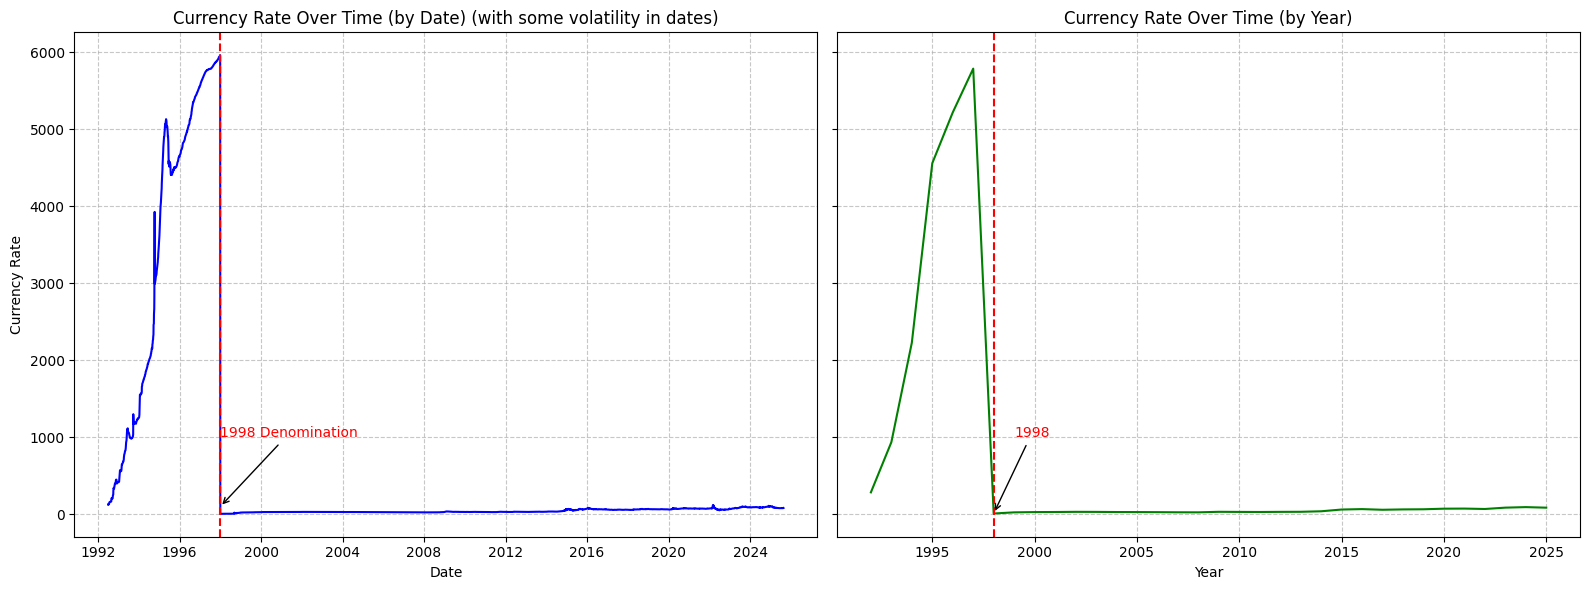

In [270]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="currency_rate", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)


denom_date = pd.to_datetime("1998-01-01")
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, 100), 
                xytext=(denom_date, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['currency_rate'].mean()
sns.lineplot(data=yearly, x="year", y="currency_rate", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)

# 1998
axs[1].axvline(1998, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998", 
                xy=(1998, yearly[yearly["year"] == 1998]["currency_rate"].values[0]),
                xytext=(1999, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

On the plots above:
* Left: You can see the wild swings in the 1990s and then the sudden drop in 1998.
* Right: When viewed yearly, the shift is even clearer — the ruble was “reset,” but the story of volatility continued later.

In [271]:
data['currency_rate_change'] = data['currency_rate'].pct_change() * 100

# find the date with the largest absolute percentage change
significant_change = data.loc[data['currency_rate_change'].abs().idxmax()]
significant_change_date = significant_change['date']
significant_change_value = significant_change['currency_rate_change']

significant_change_date, significant_change_value

(Timestamp('1998-01-01 00:00:00'), np.float64(-99.9))

On January 1, 1998, the Russian government implemented a 1,000:1 currency redenomination, replacing old banknotes with new ones to simplify the monetary system after a period of high inflation. This adjustment is clearly visible in the data, with a sharp drop in the exchange rate between December 30, 1997, and January 1, 1998.

In [272]:
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,currency_rate_change
794,5955.000,1997-12-25,1997,0.084034
795,5955.000,1997-12-26,1997,0.000000
796,5958.000,1997-12-27,1997,0.050378
797,5960.000,1997-12-30,1997,0.033568
798,5.960,1998-01-01,1998,-99.900000
799,5.963,1998-01-06,1998,0.050336
800,5.969,1998-01-07,1998,0.100620


However, in raw historical exchange rate data, this redenomination appears as a sudden and misleading drop. This can distort time series analysis, causing incorrect trend detection, volatility estimation, or model training.

To address this, I take two key steps:

* Labeling Pre- and Post-Denomination Periods.
I create a new column called denomination that marks each observation as either:
	- "pre" if it occurred before or on 1997-12-30 (in old rubles)
	- "post" if it occurred after (in new rubles)

* Normalizing the Exchange Rate. 
	- I divide all pre-denomination exchange rates by 1000 so that the entire time series is expressed in consistent units (post-1998 rubles).

In [275]:
# label data with pre and post denomination
data["denomination"] = np.where(data["date"] <= "1997-12-30", "pre", "post")

# normilize currency rate
data["RUB"] = np.where(data["denomination"] == "pre", data["currency_rate"]/1000, data["currency_rate"])
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,currency_rate_change,denomination,RUB
794,5955.000,1997-12-25,1997,0.084034,pre,5.955
795,5955.000,1997-12-26,1997,0.000000,pre,5.955
796,5958.000,1997-12-27,1997,0.050378,pre,5.958
797,5960.000,1997-12-30,1997,0.033568,pre,5.960
798,5.960,1998-01-01,1998,-99.900000,post,5.960
799,5.963,1998-01-06,1998,0.050336,post,5.963
800,5.969,1998-01-07,1998,0.100620,post,5.969


After correcting and normalizing data plots looking better.

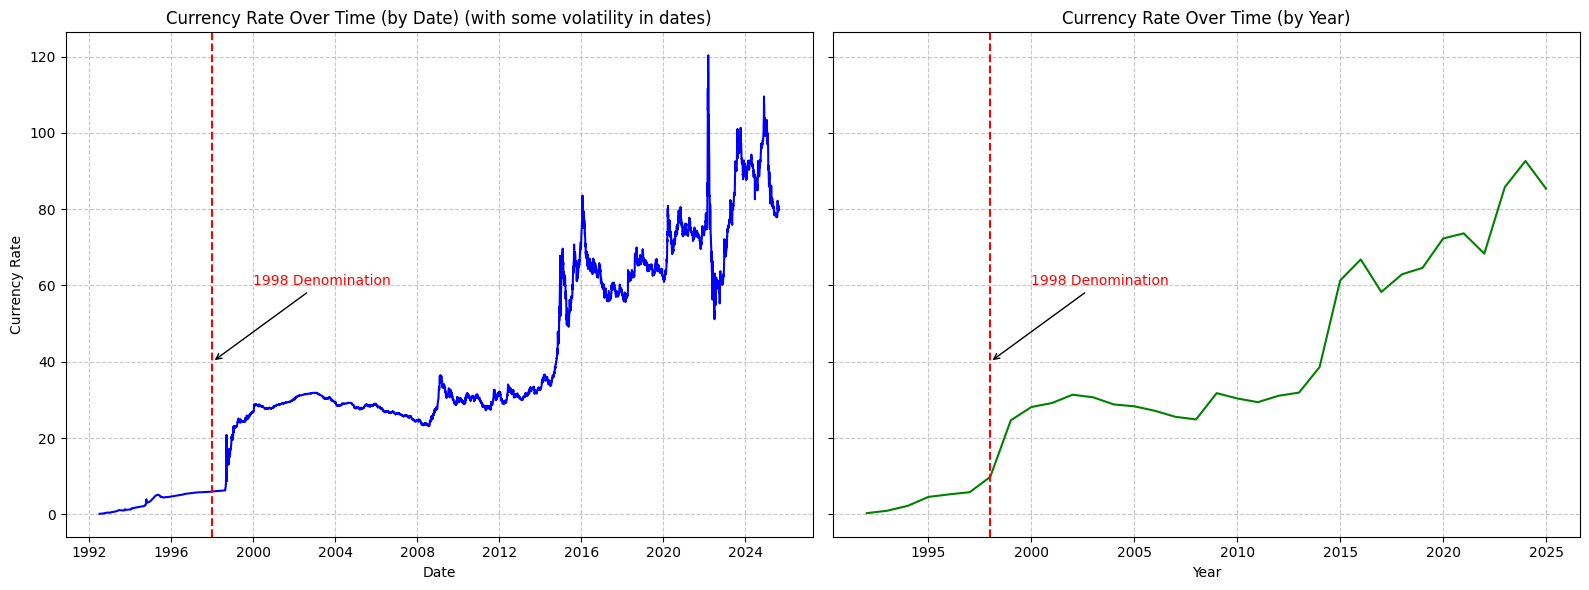

In [276]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

denom_date = pd.to_datetime("1998-01-01")
arrow_y = 40
text_y = 60
text_x = pd.to_datetime("2000-01-01")

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="RUB", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, arrow_y), 
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")



# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['RUB'].mean()
sns.lineplot(data=yearly, x="year", y="RUB", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)
arrow_year = 1998
text_year = 2000
axs[1].axvline(arrow_year, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998 Denomination", 
                xy=(arrow_year, arrow_y), 
                xytext=(text_year, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [235]:
data_year = data.groupby("year").agg({"RUB": "mean"}).reset_index()
data_year.head()

,year,RUB
0,1992,0.284345
1,1993,0.936061
2,1994,2.227129
3,1995,4.558707
4,1996,5.217653


The chart shows the long-term trend of the ruble over the years. After its denomination in 1998, the ruble gradually depreciated, with periods of relative stability followed by renewed declines. Overall, the currency has shown a clear tendency to weaken over time, reflecting broader economic and structural challenges.


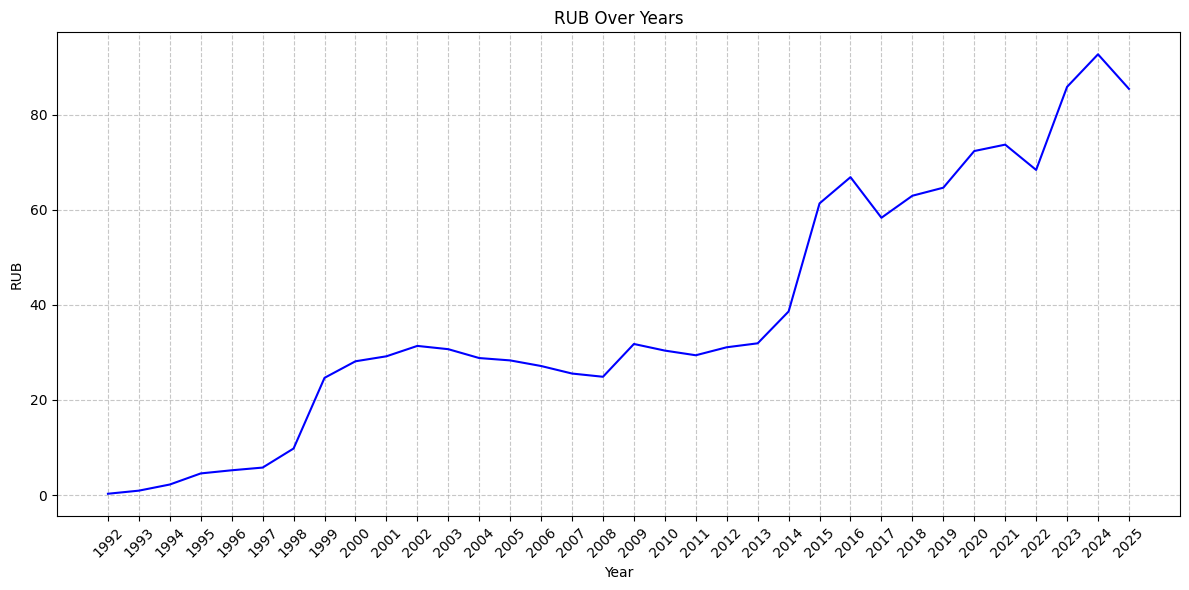

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_year, x="year", y="RUB", color="blue")

plt.xlabel("Year")
plt.ylabel("RUB")
plt.title("RUB Over Years")
plt.xticks(ticks=data_year["year"], labels=data_year["year"], rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### 2. Key Events Shaping the Ruble

Now, to better understand the main drivers of ruble fluctuations, I highlight several major economic and geopolitical shocks on the timeline.
These events represent turning points where external crises or domestic policies significantly impacted the ruble’s trajectory:
* 1998 Default – August 17, 1998
* 2008 Global Financial Crisis – September 15, 2008
* 2014 Crimea – March 1, 2014
* 2020 COVID-19 Pandemic – March 11, 2020
* 2022 Russian Invasion of Ukraine – February 24, 2022

The following chart overlays these shocks on the ruble’s historical path to illustrate how closely currency movements align with key crises.

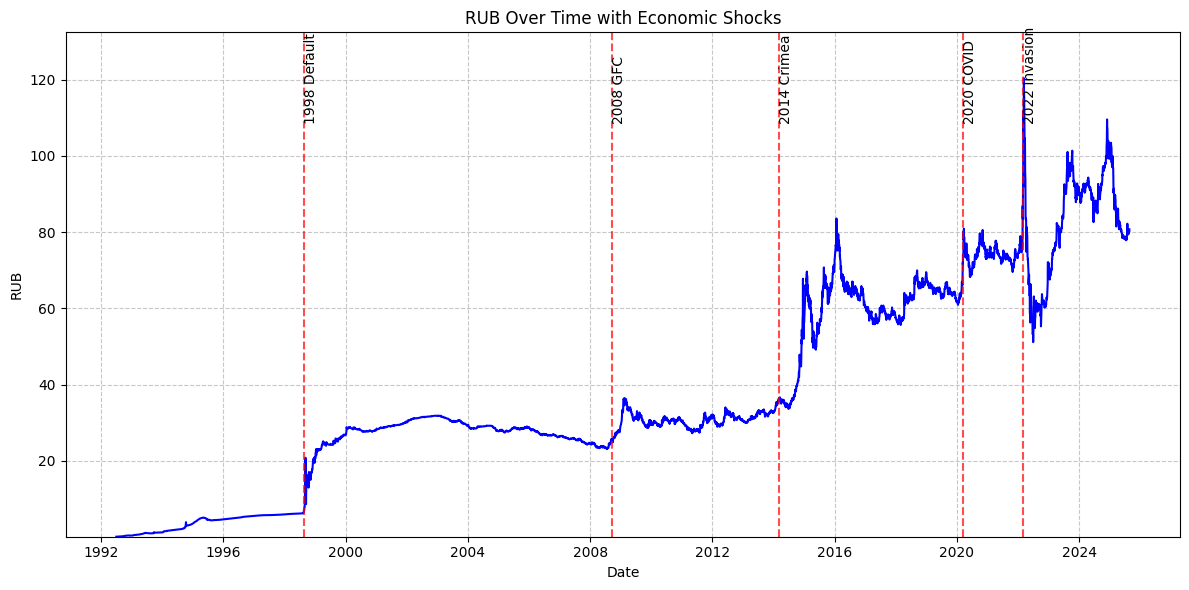

In [ ]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="RUB", color="blue")

for label, date in shocks.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')


plt.ylim(data['RUB'].min() * 0.9, data['RUB'].max() * 1.1)
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time with Economic Shocks")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Each crisis left a lasting mark, pushing the currency to a new, weaker baseline rather than fully reverting. This pattern suggests that the ruble is highly sensitive to external pressures — both economic (global financial crises, oil prices) and geopolitical (sanctions, conflicts). Instead of smooth cyclical behavior, the ruble evolves through structural breaks that reset its long-term trajectory.

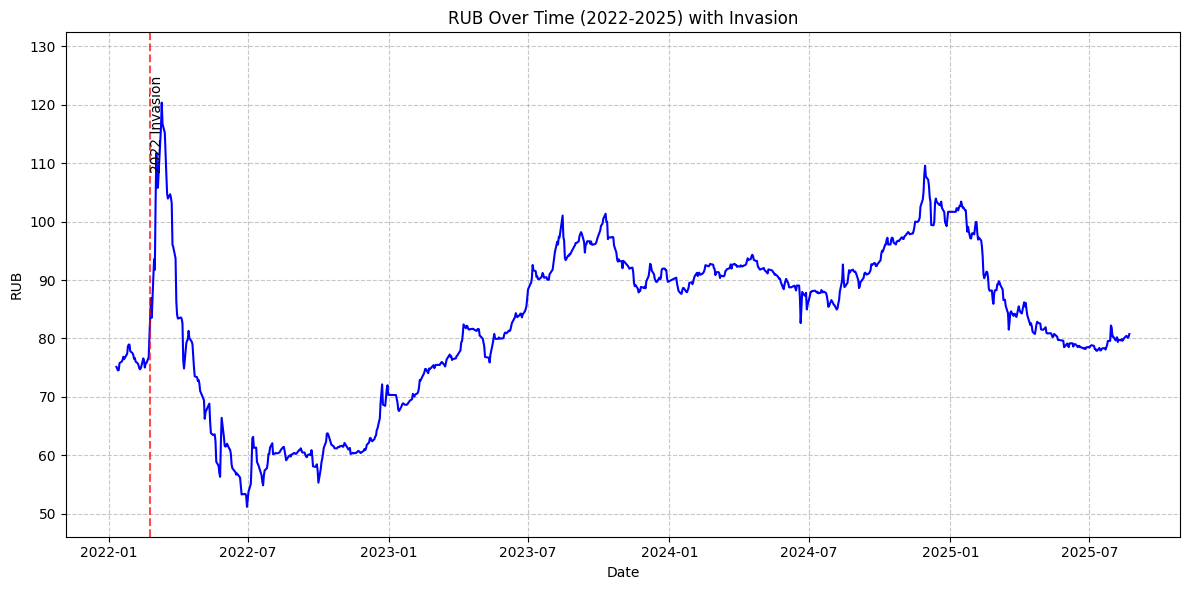

In [284]:
# Zoom-In Plot
# Filter data for the years 2022-2025 to see how currency rate changed after 2022 Invasion


filtered_data = data[(data["year"] >= 2022) & (data["year"] <= 2025)]


plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="date", y="RUB", color="blue")

for label, date in shocks.items():
    shock_date = pd.to_datetime(date)
    if shock_date.year >= 2022 and shock_date.year <= 2025:
        plt.axvline(shock_date, color='red', linestyle='--', alpha=0.7)
        plt.text(shock_date, filtered_data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')

plt.ylim(filtered_data['RUB'].min() * 0.9, filtered_data['RUB'].max() * 1.1)


plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time (2022-2025) with Invasion")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The plot above zooms into the most recent period (2022–2025), starting with the sharp depreciation following the Russian invasion of Ukraine in February 2022. The ruble spiked briefly above 120 per dollar but then quickly strengthened, supported by capital controls and high energy export revenues.

#### 3.Loading Macroeconomic Data

To model and understand ruble volatility from 1992 to 2025, I incorporate several macroeconomic variables that are known to influence exchange rates in emerging markets.

* 		GDP_per_capita (current US $)

	Captures price level changes across the economy — a broader measure of inflation. Useful for understanding real versus nominal economic growth and how inflationary pressures affect currency valuation

* 		GDP_deflator (annual %)

	Captures price level changes across the economy — a broader measure of inflation. Useful for understanding real versus nominal economic growth and how inflationary pressures affect currency valuation.

* 		FD_investment (Foreign Direct Investment)

	Measures long-term capital inflows. Rising FDI generally strengthens a currency, as it reflects investor confidence. Capital flight or reduced FDI often weakens the ruble.

* 		Inflation (CPI or general inflation)

	High inflation tends to erode purchasing power, leading to depreciation of the ruble. Low and stable inflation helps maintain exchange rate stability.

* 		Brent_Crude_Oil (USD per barrel)

	Oil exports are a major revenue source for Russia. The ruble is highly sensitive to oil prices — when oil prices rise, the ruble typically appreciates; when they fall, the ruble weakens.

* ❗❗ Metrics_2025 (Manually collected 2025 estimates) ❗❗

Because 2025 is not yet complete, I manually collected provisional data to extend the time series. While these values may later be revised, they allow me to build forecasts and test models using the most up-to-date available estimates.


In [ ]:
GDP_per_capita = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/GDP per capita (current US$).csv",skiprows=4)
GDP_deflator = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/GDP deflator (annual %).csv", skiprows=4)
FD_investment = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Foreign direct investment.csv", skiprows=4)
Inflation = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Inflation.csv", skiprows=4)
Brent_Crude_Oil = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/chart_20250912T211212.csv")
Metrics_2025 = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/2025 Metrics.csv")

In [ ]:
GDP_per_capita_RUS = GDP_per_capita[GDP_per_capita["Country Code"] == "RUS"]

GDP_per_capita_RUS = GDP_per_capita_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_per_capita_RUS = GDP_per_capita_RUS.reset_index()
GDP_per_capita_RUS.columns = ["year", "GDP_per_capita"]
GDP_per_capita_RUS = GDP_per_capita_RUS[GDP_per_capita_RUS["year"].str.isdigit()]
GDP_per_capita_RUS = GDP_per_capita_RUS.dropna()


if 2025 not in GDP_per_capita_RUS["year"].astype(int).values:
    row_2025 = Metrics_2025.loc[Metrics_2025["Metric"] == "GDP_per_capita", ["year", "Value"]].rename(columns={"Value": "GDP_per_capita"})
    GDP_per_capita_RUS = pd.concat([GDP_per_capita_RUS, row_2025], ignore_index=True)
    GDP_per_capita_RUS["year"] = GDP_per_capita_RUS["year"].astype(int)
    GDP_per_capita_RUS = GDP_per_capita_RUS.sort_values("year").reset_index(drop=True)

GDP_per_capita_RUS.tail()

,year,GDP_per_capita
33,2021,12425.029297
34,2022,15619.614258
35,2023,14159.387695
36,2024,14889.018555
37,2025,14260.000000


In [ ]:
GDP_deflator_RUS = GDP_deflator[GDP_deflator["Country Code"] == "RUS"]
GDP_deflator_RUS = GDP_deflator_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
GDP_deflator_RUS = GDP_deflator_RUS.reset_index()
GDP_deflator_RUS.columns = ["year", "GDP_deflator"]
GDP_deflator_RUS = GDP_deflator_RUS[GDP_deflator_RUS["year"].str.isdigit()]
GDP_deflator_RUS["year"] = GDP_deflator_RUS["year"].astype(int)


if 2025 not in GDP_deflator_RUS["year"].values:
    row_2025 = Metrics_2025.loc[Metrics_2025["Metric"] == "GDP_deflator", ["year", "Value"]].rename(columns={"Value": "GDP_deflator"})
    row_2025["year"] = row_2025["year"].astype(int)
    GDP_deflator_RUS = pd.concat([GDP_deflator_RUS, row_2025], ignore_index=True)
    GDP_deflator_RUS = GDP_deflator_RUS.sort_values("year").reset_index(drop=True)

GDP_deflator_RUS.tail()

,year,GDP_deflator
61,2021,18.209101
62,2022,18.184689
63,2023,7.998571
64,2024,9.275671
65,2025,8.200000


In [ ]:
FD_investment_RUS = FD_investment[FD_investment["Country Code"] == "RUS"]
FD_investment_RUS = FD_investment_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
FD_investment_RUS = FD_investment_RUS.reset_index()
FD_investment_RUS.columns = ["year", "FD_investment"]
FD_investment_RUS = FD_investment_RUS[FD_investment_RUS["year"].str.isdigit()]
FD_investment_RUS = FD_investment_RUS.dropna()
FD_investment_RUS["year"] = FD_investment_RUS["year"].astype(int)

if 2025 not in FD_investment_RUS["year"].values:
    row_2025 = Metrics_2025.loc[Metrics_2025["Metric"] == "FD_investment", ["year", "Value"]].rename(columns={"Value": "FD_investment"})
    row_2025["year"] = row_2025["year"].astype(int)
    FD_investment_RUS = pd.concat([FD_investment_RUS, row_2025], ignore_index=True)
    FD_investment_RUS = FD_investment_RUS.sort_values("year").reset_index(drop=True)

FD_investment_RUS.tail()

,year,FD_investment
29,2021,4.045000e+10
30,2022,-3.980094e+10
31,2023,-1.004511e+10
32,2024,-8.175980e+09
33,2025,3.300000e+09


In [ ]:
Inflation_RUS = Inflation[Inflation["Country Code"] == "RUS"]
Inflation_RUS = Inflation_RUS.drop(columns=["Country Name", "Country Code", "Indicator Name", "Indicator Code"]).T
Inflation_RUS = Inflation_RUS.reset_index()
Inflation_RUS.columns = ["year", "Inflation"]
Inflation_RUS = Inflation_RUS[Inflation_RUS["year"].str.isdigit()]
Inflation_RUS["year"] = Inflation_RUS["year"].astype(int)
Inflation_RUS = Inflation_RUS.dropna()

if 2025 not in Inflation_RUS["year"].values:
    row_2025 = Metrics_2025.loc[Metrics_2025["Metric"] == "Inflation", ["year", "Value"]].rename(columns={"Value": "Inflation"})
    row_2025["year"] = row_2025["year"].astype(int)
    Inflation_RUS = pd.concat([Inflation_RUS, row_2025], ignore_index=True)
    Inflation_RUS = Inflation_RUS.sort_values("year").reset_index(drop=True)

Inflation_RUS.tail()

,year,Inflation
31,2021,18.209101
32,2022,18.184689
33,2023,7.998571
34,2024,9.275671
35,2025,8.140000


In [245]:
Brent_Crude_Oil["year"] = pd.to_datetime(Brent_Crude_Oil["Date"]).dt.year
Brent_Crude_Oil["month"] = pd.to_datetime(Brent_Crude_Oil["Date"]).dt.month
Brent_Crude_Oil = Brent_Crude_Oil.rename(columns={'Value': 'Brent_price'})
Brent_Crude_Oil = Brent_Crude_Oil[Brent_Crude_Oil["year"]>1991]

Brent_Crude_Oil.tail()

,Date,Brent_price,year,month
456,05/30/2025,64.32,2025,5
457,06/30/2025,68.15,2025,6
458,07/31/2025,73.43,2025,7
459,08/29/2025,67.83,2025,8
460,09/08/2025,65.44,2025,9


In [246]:
GDP_per_capita_RUS["year"] = GDP_per_capita_RUS["year"].astype(int)

data = pd.merge(data, GDP_per_capita_RUS, on="year", how="left")
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.0
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.0
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.0
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.0
7669,80.7498,2025-08-22,2025,3,8,22,5,False,0.616786,post,80.7498,14260.0


In [247]:
Brent_Crude_Oil_merge = Brent_Crude_Oil[['year', 'month', 'Brent_price']].copy() 
data = pd.merge(data, Brent_Crude_Oil_merge, on=['year', 'month'], how='left')

In [248]:
GDP_deflator_RUS["year"] = GDP_deflator_RUS["year"].astype(int)
FD_investment_RUS["year"] = FD_investment_RUS["year"].astype(int)
Inflation_RUS["year"] = Inflation_RUS["year"].astype(int)
data = pd.merge(data, GDP_deflator_RUS, on="year", how="left")
data = pd.merge(data, FD_investment_RUS, on="year", how="left")
data = pd.merge(data, Inflation_RUS, on="year", how="left")

In [154]:
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.0,67.83,8.2,3.300000e+09,8.14
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.0,67.83,8.2,3.300000e+09,8.14
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.0,67.83,8.2,3.300000e+09,8.14
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.0,67.83,8.2,3.300000e+09,8.14
7669,80.7498,2025-08-22,2025,3,8,22,5,False,0.616786,post,80.7498,14260.0,67.83,8.2,3.300000e+09,8.14


In [157]:
daily_data = data
daily_data.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Daily_Data.csv", index=False)

In [249]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
monthly_data = data.resample('ME').agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[-1])
monthly_data = monthly_data.reset_index()
monthly_data.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv", index=False)
monthly_data.tail()


,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,83.243645,14260.0,63.37,8.2,3.300000e+09,8.14
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,80.237650,14260.0,64.32,8.2,3.300000e+09,8.14
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,78.677635,14260.0,68.15,8.2,3.300000e+09,8.14
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,78.850139,14260.0,73.43,8.2,3.300000e+09,8.14
397,2025-08-31,80.013656,2025.0,3.0,8.0,12.250000,3.125000,0.0,0.034674,post,80.013656,14260.0,67.83,8.2,3.300000e+09,8.14


This plot displays the normalized trends of the Russian ruble (RUB) exchange rate, GDP per capita (current US$), and Brent crude oil prices from 1992 to 2025. Normalization allows for comparison across different units by scaling all values between 0 and 1.

Key highlights:
- The **1998 financial crisis** and currency redenomination are clearly visible as sharp movements in the RUB series.
- The **2000s oil boom** shows strong upward trends in both oil prices and GDP per capita, with the ruble also appreciating during this period.
- The **2008 global financial crisis** and the **2014–2015 oil price collapse and sanctions** result in synchronized drops across all three indicators.
- Post-2020, increased **volatility** is observed due to the COVID-19 pandemic, geopolitical tensions, and energy market fluctuations.

This comparison helps illustrate how external shocks (like oil price changes) and internal factors (such as inflation or economic growth) jointly influence the ruble's long-term volatility.

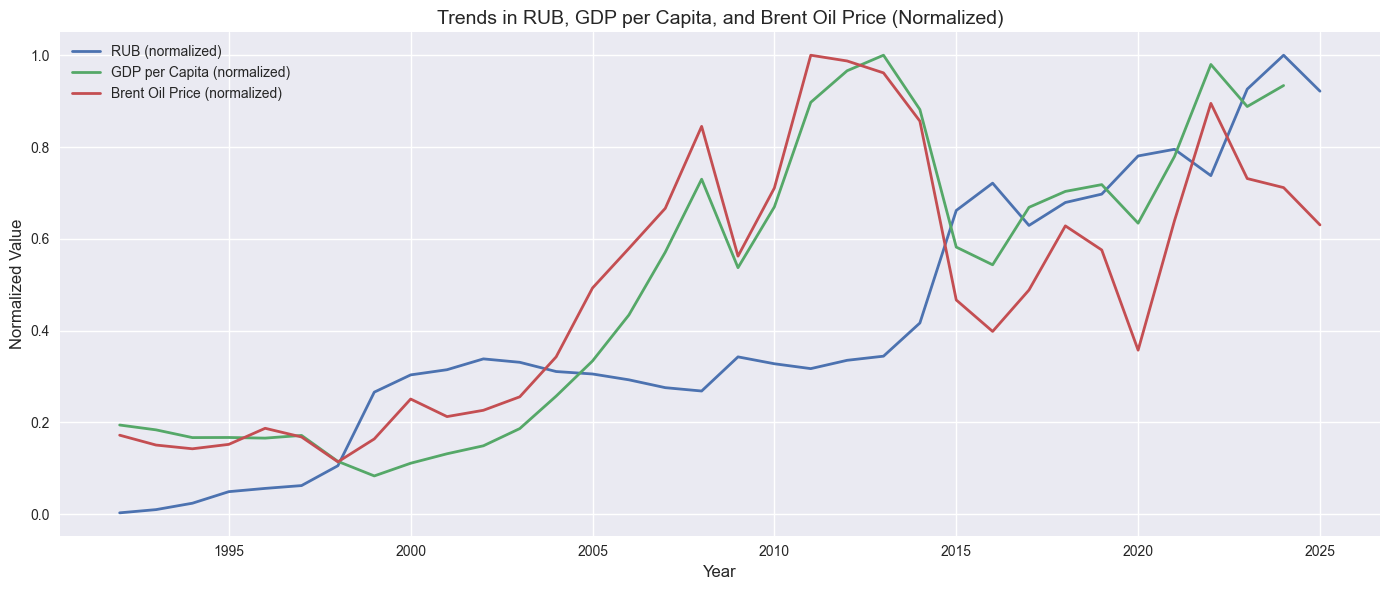

In [ ]:
annual_data = data.groupby("year").agg({
    "RUB": "mean",
    "GDP_per_capita": "mean",
    "Brent_price": "mean"
}).reset_index()


annual_data["RUB_norm"] = annual_data["RUB"] / annual_data["RUB"].max()
annual_data["GDP_norm"] = annual_data["GDP_per_capita"] / annual_data["GDP_per_capita"].max()
annual_data["Brent_norm"] = annual_data["Brent_price"] / annual_data["Brent_price"].max()

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB_norm"], label="RUB (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["GDP_norm"], label="GDP per Capita (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Brent_norm"], label="Brent Oil Price (normalized)", linewidth=2)

# Step 4: Format plot
plt.title("Trends in RUB, GDP per Capita, and Brent Oil Price (Normalized)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Summary:

This notebook prepared and cleaned historical data for RUB exchange rates and major economic indicators (GDP per capita, FDI, inflation, oil prices). 

Next steps:
- Perform exploratory analysis and correlation studies
- Fit ARIMA/ARIMAX/GARCH models to study ruble volatility
- Run event studies and synthetic control methods to assess causal shocks